In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from time import time
import pandas as pd
import seaborn as sns
import argparse
from scipy import signal
import skfuzzy as fuzz
from skimage.exposure import rescale_intensity

In [55]:
## Configure some general styling
sns.set_style("white")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = (8,7)
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

In [31]:
def show_plane(ax, plane, cmap="viridis", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)
        
    # Define the necessary functions
def getTheFile(filename,rows,cols,start,stop):
    from denpy import DEN
    arr = np.empty([rows, cols, 0])    
    for i in range(start,stop,1):
        Frame = DEN.getFrame(filename, i, row_from=None, row_to=None, col_from=None, col_to=None)
        dentoarr = np.asarray(Frame)
        dentoarr = np.expand_dims(dentoarr, axis=2)
        arr = np.concatenate((arr, dentoarr), axis=2)
    return arr

# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

def MyCC3d(labeledarr,originalarr):
    import cc3d
    from skimage import segmentation,measure,morphology
    print("computing cc3d")
    labels_out = cc3d.connected_components(labeledarr)
    print("removing small size objects to decrease the output labels")
    interior_labels = morphology.remove_small_objects(labels_out, min_size=300)
    print("relabelling")
    relabeled, _, _ = segmentation.relabel_sequential(interior_labels)
    print("computing the objects properties")
    regionprops = measure.regionprops(relabeled, intensity_image=originalarr)
    print("Computing the areas")
    areas = [regionprop.area for regionprop in regionprops]
    return relabeled,regionprops,areas

def computeAvgDraw(frames):
    print("calculating the average from each frame")
    yvalues =[]
    xvalues = range(frames.shape[2])
    for i in range(frames.shape[2]):
        avg = np.average(frames[:,:,i]!= 0)
        yvalues.append(avg)
    
    print("Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve")
    return xvalues,yvalues

In [32]:
class FCM():
    def __init__(self,image,n_clusters,m=2,kernel_size=5,
            kernel_shape='uniform',lam=0.5,epsilon=0.05,max_iter=300):
        '''Spatial intuitionistic Fuzzy C-means clustering on image

        <image>: 2D array, grey scale image. Can be of int type or float.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <kernel_size>: int >= 1, size of neighborhood.
        <kernel_shape>: str, 'uniform': equally weighted kernel function in
                                        summing weights in neighborhood.
                             'gaussian': gaussian weights for summing neighborhood.
        <lam>: float > 0, intuitionistic fuzzy parameter?
        <epsilon>: float > 0, threshold to check convergence.
        <max_iter>: int, max number of iterations.

        Author: guangzhi XU (xugzhi1987@gmail.com; guangzhi.xu@outlook.com)
        Update time: 2018-04-28 17:50:10.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if kernel_size <=0 or kernel_size != int(kernel_size):
            raise Exception("<kernel_size> needs to be positive integer.")
        if kernel_shape not in ['uniform', 'gaussian']:
            raise Exception("<kernel_shape> needs to be one of 'uniform', 'gaussian'.")
        if lam <= 0:
            raise Exception("<lam> needs to be > 0.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.kernel_size = kernel_size
        self.kernel_shape = kernel_shape
        self.lam = lam
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size

        #-----------------Initial weights-----------------
        self.U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            self.U[idxii,ii] = 1

        #-----------------Initial centers-----------------
        self.C = np.linspace(np.min(image),np.max(image),n_clusters)
        self.C = self.C.reshape(self.n_clusters,1)

        #---------------Neighbourhood kernel---------------
        if kernel_shape == 'uniform':
            self.kernel = np.ones([kernel_size,kernel_size,1])
        if kernel_shape == 'gaussian':
            radius = max(1,int(kernel_size/.2))
            stdr = max(1,int(radius/.2))
            self.kernel = getGaussianElement(radius,radius,stdr,stdr)

        #----------------Initial hesitation----------------
        self.hesitation = 1.-self.U-(1.-self.U)/(1.+2.*self.U)


    def update_U(self):
        '''Compute weights'''
        c_mesh,x_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(x_mesh-c_mesh)**power
        p2 = np.sum((1./abs(x_mesh-c_mesh))**power,axis=1)

        return 1./(p1*p2[:,None])


    def update_C(self):
        '''Compute centroid of clusters'''
        num = np.dot(self.X,self.U**self.m)
        den = np.sum(self.U**self.m,axis=0)

        return num/den


    def calculate_h(self):
        '''Compute neighbourhood weights'''
        kernel = np.ones((5,5,1))
        uu = self.U.reshape((self.shape+(self.n_clusters,)))
        h = signal.fftconvolve(uu,kernel,mode='same')
        h = h.reshape(self.U.shape)

        return h

    def compute_intuitionistic_U(self):
        '''Compute intuitionistic U'''
        self.hesitation=1.-self.U-(1-self.U)/(1+self.lam*self.U)

        return self.U+self.hesitation


    def computeNew_U(self):
        '''Compute new weights after incorporating spatial and intuitionistic'''
        p = 1
        #q = 2
        q = 3
        self.h = self.calculate_h()
        num=self.U**p*self.h**q
        denom=num.sum(axis=1)
        denom=np.outer(denom,1+np.arange(self.n_clusters))

        return num/denom


    def computeIntraDists(self):
        '''Compute mean intra cluster distances'''

        result = self.deFuzzify()
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        dist=abs(c_mesh-x_mesh)
        idx=np.arange(self.n_clusters)
        match=result[:,None]-idx[None,:]
        _,count=np.unique(self.result,return_counts=True)
        sigma=(dist*(match==0)).sum(axis=0)/count

        return sigma


    def calculate_DB_score(self):
        '''Compute DB index

        DB = 1/c * \sum_{1}^{c} max_{i != j} ( (s_i + s_j) / d_{i,j} )

        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        c is the number of clusters
        '''

        sigmas = self.computeIntraDists()

        rs=sigmas[:,None]+sigmas[None,:]
        dists=abs(self.C[:,None]-self.C[None,:])
        np.fill_diagonal(dists,np.nan)
        rs=rs/dists
        ds=np.nanmax(rs,axis=0)
        DB_score=ds.sum()/self.n_clusters

        print("DB_score = %f" %DB_score)

    def calculate_D_score(self):
        '''Compute Dunn index

        D = min{ min { d_{i,j} / max {s_k} } }

        the ratio of min inter-cluster distance to max  intra-cluster distance

        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        '''

        sigmas = self.computeIntraDists()

        denom=np.max(sigmas)
        dists=abs(self.C[:,None]-self.C[None,:])/denom
        np.fill_diagonal(dists,np.inf)
        D_score=np.min(dists)

        print("D_score = %f" %D_score)


    def calculate_scores(self):

        #--------------Partition coefficient--------------
        self.vpc=(self.U**2).sum()/self.numPixels
        print("VPC =  %f" %self.vpc)

        #----------------Partition entropy----------------
        vpe=self.U*np.log(self.U)
        self.vpe=-1*vpe.sum()/self.numPixels
        print("VPE = %f" %self.vpe)

        #------------------Cost function------------------
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        numer=(self.U*(x_mesh-c_mesh)**2).sum()
        denom=self.numPixels*(self.C[0]-self.C[1])**2
        self.vxb=numer/denom
        print("VXB = %f" %self.vxb)

        #-------------DB scorea nd Dunn index-------------
        self.calculate_DB_score()
        self.calculate_D_score()


    def form_clusters(self):
        '''Iterative training'''

        d = 100
        if self.max_iter != -1:
            i = 0
            while True:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                self.U = self.compute_intuitionistic_U()
                self.U = self.computeNew_U()
                #d = sum(abs(sum(self.U_new - old_u)))
                # this way of computing d is faster
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        else:
            i = 0
            while d > self.epsilon:
                self.update_C()
                old_u = np.copy(self.U)
                self.update_U()
                d = sum(abs(sum(self.U - old_u)))
                print ("loop : " , int(i))
                print (d)
                self.segmentImage(i)
                i+=1

        self.segmentImage()


    def deFuzzify(self):
        return np.argmax(self.U, axis = 1)


    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')
        return self.result

    def __init__(self,image,n_clusters,m=2,kernel_size=5,
            kernel_shape='uniform',lam=0.5,epsilon=0.05,max_iter=300):
        '''Spatial intuitionistic Fuzzy C-means clustering on image

        <image>: 2D array, grey scale image. Can be of int type or float.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <kernel_size>: int >= 1, size of neighborhood.
        <kernel_shape>: str, 'uniform': equally weighted kernel function in
                                        summing weights in neighborhood.
                             'gaussian': gaussian weights for summing neighborhood.
        <lam>: float > 0, intuitionistic fuzzy parameter?
        <epsilon>: float > 0, threshold to check convergence.
        <max_iter>: int, max number of iterations.

        Author: guangzhi XU (xugzhi1987@gmail.com; guangzhi.xu@outlook.com)
        Update time: 2018-04-28 17:50:10.
        '''

        #-------------------Check inputs-------------------
        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be positive integer.")
        if m < 1:
            raise Exception("<m> needs to be >= 1.")
        if kernel_size <=0 or kernel_size != int(kernel_size):
            raise Exception("<kernel_size> needs to be positive integer.")
        if kernel_shape not in ['uniform', 'gaussian']:
            raise Exception("<kernel_shape> needs to be one of 'uniform', 'gaussian'.")
        if lam <= 0:
            raise Exception("<lam> needs to be > 0.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.image = image
        self.n_clusters = n_clusters
        self.m = m
        self.kernel_size = kernel_size
        self.kernel_shape = kernel_shape
        self.lam = lam
        self.epsilon = epsilon
        self.max_iter = max_iter

        self.shape = image.shape
        self.X = image.flatten().astype('float')
        self.numPixels = image.size

        #-----------------Initial weights-----------------
        self.U = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx%self.n_clusters==ii
            self.U[idxii,ii] = 1

        #-----------------Initial centers-----------------
        self.C = np.linspace(np.min(image),np.max(image),n_clusters)
        self.C = self.C.reshape(self.n_clusters,1)

        #---------------Neighbourhood kernel---------------
        if kernel_shape == 'uniform':
            self.kernel = np.ones([kernel_size,kernel_size,1])
        if kernel_shape == 'gaussian':
            radius = max(1,int(kernel_size/.2))
            stdr = max(1,int(radius/.2))
            self.kernel = getGaussianElement(radius,radius,stdr,stdr)

        #----------------Initial hesitation----------------
        self.hesitation = 1.-self.U-(1.-self.U)/(1.+2.*self.U)


    def update_U(self):
        '''Compute weights'''
        c_mesh,x_mesh = np.meshgrid(self.C,self.X)
        power = 2./(self.m-1)
        p1 = abs(x_mesh-c_mesh)**power
        p2 = np.sum((1./abs(x_mesh-c_mesh))**power,axis=1)

        return 1./(p1*p2[:,None])


    def update_C(self):
        '''Compute centroid of clusters'''
        num = np.dot(self.X,self.U**self.m)
        den = np.sum(self.U**self.m,axis=0)

        return num/den


    def calculate_h(self):
        '''Compute neighbourhood weights'''
        kernel = np.ones((5,5,1))
        uu = self.U.reshape((self.shape+(self.n_clusters,)))
        h = signal.fftconvolve(uu,kernel,mode='same')
        h = h.reshape(self.U.shape)

        return h

    def compute_intuitionistic_U(self):
        '''Compute intuitionistic U'''
        self.hesitation=1.-self.U-(1-self.U)/(1+self.lam*self.U)

        return self.U+self.hesitation


    def computeNew_U(self):
        '''Compute new weights after incorporating spatial and intuitionistic'''
        p = 1
        #q = 2
        q = 3
        self.h = self.calculate_h()
        num=self.U**p*self.h**q
        denom=num.sum(axis=1)
        denom=np.outer(denom,1+np.arange(self.n_clusters))

        return num/denom


    def computeIntraDists(self):
        '''Compute mean intra cluster distances'''

        result = self.deFuzzify()
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        dist=abs(c_mesh-x_mesh)
        idx=np.arange(self.n_clusters)
        match=result[:,None]-idx[None,:]
        _,count=np.unique(self.result,return_counts=True)
        sigma=(dist*(match==0)).sum(axis=0)/count

        return sigma


    def calculate_DB_score(self):
        '''Compute DB index

        DB = 1/c * \sum_{1}^{c} max_{i != j} ( (s_i + s_j) / d_{i,j} )

        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        c is the number of clusters
        '''

        sigmas = self.computeIntraDists()

        rs=sigmas[:,None]+sigmas[None,:]
        dists=abs(self.C[:,None]-self.C[None,:])
        np.fill_diagonal(dists,np.nan)
        rs=rs/dists
        ds=np.nanmax(rs,axis=0)
        DB_score=ds.sum()/self.n_clusters

        print("DB_score = %f" %DB_score)

    def calculate_D_score(self):
        '''Compute Dunn index

        D = min{ min { d_{i,j} / max {s_k} } }

        the ratio of min inter-cluster distance to max  intra-cluster distance

        where s_i is the mean distance between centroid i and its members,
        d_{i,j} is the centroid distance btween i and j
        '''

        sigmas = self.computeIntraDists()

        denom=np.max(sigmas)
        dists=abs(self.C[:,None]-self.C[None,:])/denom
        np.fill_diagonal(dists,np.inf)
        D_score=np.min(dists)

        print("D_score = %f" %D_score)


    def calculate_scores(self):

        #--------------Partition coefficient--------------
        self.vpc=(self.U**2).sum()/self.numPixels
        print("VPC =  %f" %self.vpc)

        #----------------Partition entropy----------------
        vpe=self.U*np.log(self.U)
        self.vpe=-1*vpe.sum()/self.numPixels
        print("VPE = %f" %self.vpe)

        #------------------Cost function------------------
        c_mesh,x_mesh=np.meshgrid(self.C,self.X)
        numer=(self.U*(x_mesh-c_mesh)**2).sum()
        denom=self.numPixels*(self.C[0]-self.C[1])**2
        self.vxb=numer/denom
        print("VXB = %f" %self.vxb)

        #-------------DB scorea nd Dunn index-------------
        self.calculate_DB_score()
        self.calculate_D_score()


    def form_clusters(self):
        '''Iterative training'''

        d = 100
        if self.max_iter != -1:
            i = 0
            while True:
                self.C = self.update_C()
                old_u = np.copy(self.U)
                self.U = self.update_U()
                self.U = self.compute_intuitionistic_U()
                self.U = self.computeNew_U()
                #d = sum(abs(sum(self.U_new - old_u)))
                # this way of computing d is faster
                d = np.sum(abs(self.U - old_u))
                print("Iteration %d : cost = %f" %(i, d))

                if d < self.epsilon or i > self.max_iter:
                    break
                i+=1
        else:
            i = 0
            while d > self.epsilon:
                self.update_C()
                old_u = np.copy(self.U)
                self.update_U()
                d = sum(abs(sum(self.U - old_u)))
                print ("loop : " , int(i))
                print (d)
                self.segmentImage(i)
                i+=1

        self.segmentImage()


    def deFuzzify(self):
        return np.argmax(self.U, axis = 1)


    def segmentImage(self):
        '''Segment image based on max weights'''

        result = self.deFuzzify()
        self.result = result.reshape(self.shape).astype('int')

        return self.result

In [33]:
#Getting the 3D-array and 2D-TestingFrame for CT 
print("File is loading ")
Carm_ICA = getTheFile("KVA_carm.den",550,550,173,192)
print("File is loaded with the shape: ",Carm_ICA.shape)
#Normalize the data  
print("Normalizing the data") 
normalized = (Carm_ICA-Carm_ICA.min())/(Carm_ICA.max()-Carm_ICA.min())

File is loading 
File is loaded with the shape:  (550, 550, 19)
Normalizing the data


In [34]:
original_shape = normalized.shape
reshaped  = normalized.reshape(-1,1)
import time
cluster = FCM(reshaped,3,m=2,epsilon=0.05,max_iter=100,kernel_shape='uniform', kernel_size=9)
print (reshaped.shape)
cluster.form_clusters()
cluster.calculate_scores()
result=cluster.result
# print("--- %s seconds ---" % (time.time() - start_time))


(5747500, 1)
Iteration 0 : cost = 6917605.485906
Iteration 1 : cost = 146480.088700
Iteration 2 : cost = 1399414.498255
Iteration 3 : cost = 3114359.574593
Iteration 4 : cost = 753968.496246
Iteration 5 : cost = 392128.019262
Iteration 6 : cost = 235478.536448
Iteration 7 : cost = 142653.374870
Iteration 8 : cost = 99199.787069
Iteration 9 : cost = 80262.771860
Iteration 10 : cost = 70267.593105
Iteration 11 : cost = 62986.577983
Iteration 12 : cost = 56507.316612
Iteration 13 : cost = 50940.619754
Iteration 14 : cost = 46506.672307
Iteration 15 : cost = 43297.398095
Iteration 16 : cost = 41264.041117
Iteration 17 : cost = 40311.203764
Iteration 18 : cost = 40286.611171
Iteration 19 : cost = 40989.732783
Iteration 20 : cost = 42119.312183
Iteration 21 : cost = 43139.683452
Iteration 22 : cost = 43223.108360
Iteration 23 : cost = 41469.595951
Iteration 24 : cost = 37493.642004
Iteration 25 : cost = 31835.576657
Iteration 26 : cost = 25590.525144
Iteration 27 : cost = 19745.097269
Iterat

In [35]:
print(result.shape)

(5747500, 1)


In [36]:
ICA = result.reshape(original_shape[0],original_shape[1],original_shape[2])

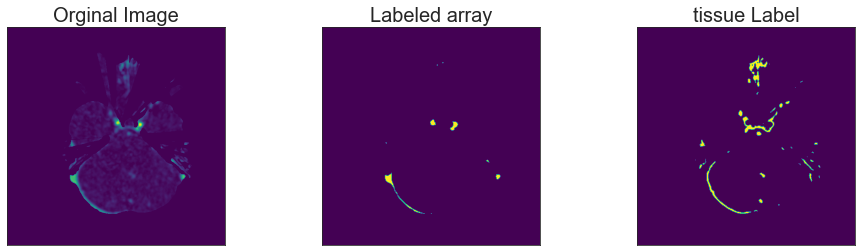

In [37]:
_, (a, b,c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, ICA[:,:,1]==0, title="Labeled array", cmap="viridis")
show_plane(c, ICA[:,:,1]==2, title="tissue Label", cmap="viridis")

In [38]:
relabeled,regionprops,areas = MyCC3d(ICA==0,Carm_ICA)

computing cc3d
removing small size objects to decrease the output labels
relabelling
computing the objects properties
Computing the areas


In [39]:
len(areas)

4

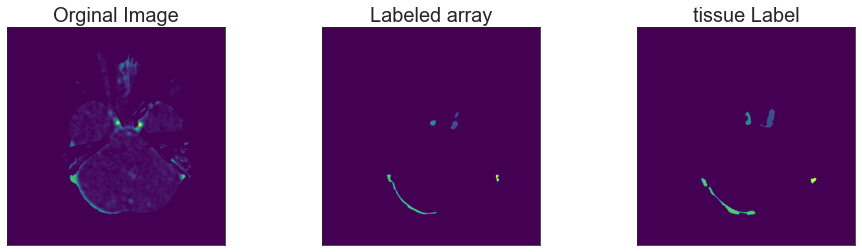

In [40]:
_, (a, b,c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, relabeled[:,:,5], title="Labeled array", cmap="viridis")
show_plane(c, relabeled[:,:,10], title="tissue Label", cmap="viridis")

In [41]:
print("labels: {}".format(np.unique(relabeled[:,:,1])))
for i in range(len(areas)):
    print("area: {}".format(areas[i]))

labels: [0 1 2 3 4]
area: 8289
area: 4733
area: 13314
area: 1721


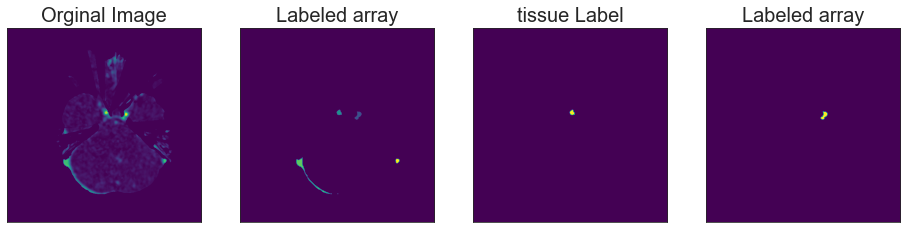

In [42]:
_, (a, b,c,d) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
show_plane(a, Carm_ICA[:,:,1], title="Orginal Image", cmap="viridis")
show_plane(b, relabeled[:,:,1], title="Labeled array", cmap="viridis")
show_plane(c, relabeled[:,:,1]==2, title="tissue Label", cmap="viridis")
show_plane(d, relabeled[:,:,1]==1, title="Labeled array", cmap="viridis")

In [47]:
L_ICA_mask = relabeled==1
L_ICA = Carm_ICA * L_ICA_mask
R_ICA_mask = relabeled==2
R_ICA = Carm_ICA * R_ICA_mask

In [48]:
 xvalues_L, yvalues_L = computeAvgDraw(L_ICA)
 xvalues_R, yvalues_R = computeAvgDraw(R_ICA)

calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve
calculating the average from each frame
Average is computed and you can use the xvalues and yvalues to draw the time attenuation curve


Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


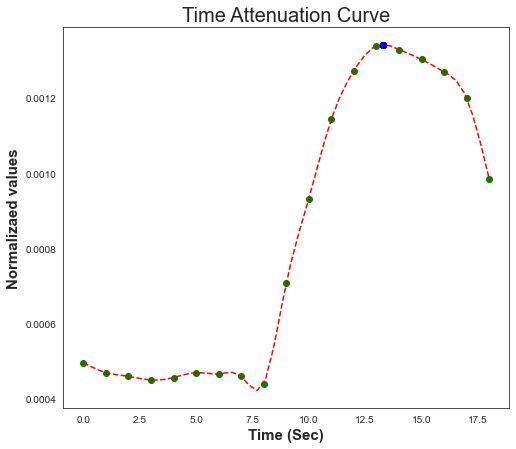

Maximum concentration = 0.0013420311054
Time to peak = 13.270973759
area = 0.040620062246549994


In [60]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
p=GEKKO()
#Parameter
xspline = p.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
yspline = p.Var()
p.cspline(xspline,yspline,xvalues,yvalues_R)
pxx=p.Var(value=1 ,lb=10,ub=16)
pyy=p.Var()
p.Obj(-pyy)
p.cspline(pxx,pyy,xvalues,yvalues_R)
#Regression Mode
p.options.IMODE = 2
#Optimize
p.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_R,'go',label='data')
plt.plot(xspline,yspline,'r--',label='cubic spline')
plt.plot(pxx,pyy,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(pyy.VALUE[1]))
print("Time to peak =", str(pxx.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(yspline)
print("area =", area)

Showing the time attenuation curve, close to continue
 The time attenuation curve as pdf and png are saved in your hard disc


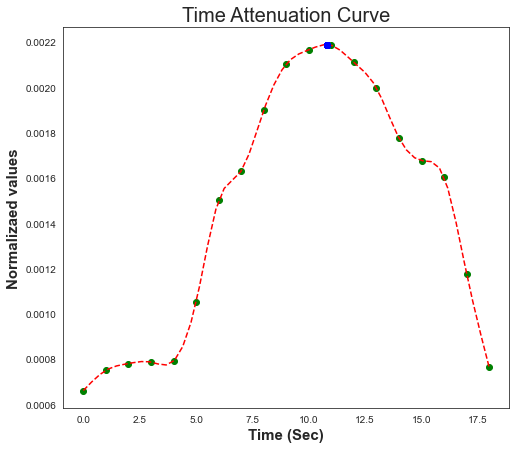

Maximum concentration = 0.0021882075871
Time to peak = 10.787992552
area = 0.07274982989204501


In [59]:
from gekko import GEKKO
xvalues = np.linspace(0,ICA.shape[2]-1,num=ICA.shape[2])
#GEKKO model
m=GEKKO()
#Parameter
mxspline = m.Param(value=np.linspace(0,ICA.shape[2]-1))
#Variable
myspline = m.Var()
m.cspline(mxspline,myspline,xvalues,yvalues_L)
px=m.Var(value=1 ,lb=10,ub=16)
py=m.Var()
m.Obj(-py)
m.cspline(px,py,xvalues,yvalues_L)
#Regression Mode
m.options.IMODE = 2
#Optimize
m.solve(disp=False)
print(" Showing the time attenuation curve, close to continue")
fig1 = plt.gcf()
plt.title('Time Attenuation Curve')
plt.plot(xvalues,yvalues_L,'go',label='data')
plt.plot(mxspline,myspline,'r--',label='cubic spline')
plt.plot(px,py,'bo',label='maximum')
plt.ylabel('Normalizaed values')
plt.xlabel('Time (Sec)')
fig1.savefig("selectedVessel.pdf")
fig1.savefig("selectedVessel.png")
print(" The time attenuation curve as pdf and png are saved in your hard disc")
plt.show()
print("Maximum concentration =", str(py.VALUE[1]))
print("Time to peak =", str(px.VALUE[1]))
from numpy import trapz
# Compute the area using the composite trapezoidal rule.
area = trapz(myspline)
print("area =", area)

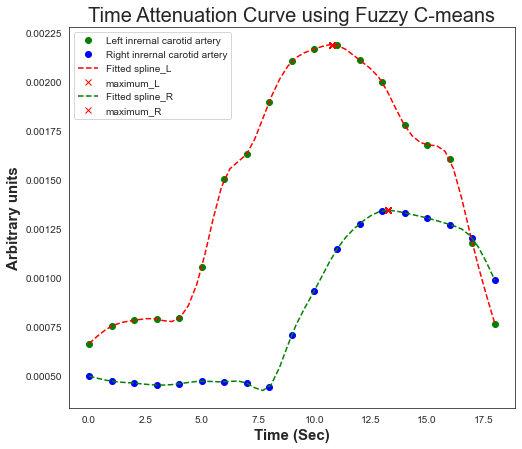

In [61]:
fig2 = plt.gcf()
plt.title('Time Attenuation Curve using Fuzzy C-means')

plt.plot(xvalues,yvalues_L,'go',label='Left inrernal carotid artery')
plt.plot(xvalues,yvalues_R,'bo',label='Right inrernal carotid artery')
plt.plot(mxspline,myspline,'r--',label='Fitted spline_L')
plt.plot(px,py,'rx',label='maximum_L')


plt.plot(xspline,yspline,'g--',label='Fitted spline_R')
plt.plot(pxx,pyy,'rx',label='maximum_R')
plt.ylabel('Arbitrary units')
plt.xlabel('Time (Sec)')
plt.legend()